Amparo Godoy Pastore


# Age and Gender Prediction with UTKFace Dataset: Data Preprocessing, Exploratory Analysis, and Model Training using CNNs and Transformers

# 1. Data Preprocessing

In [12]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

image_dir = 'part3'

# lists to hold images and labels
images = []
ages = []
genders = []

# Load images and labels
for file_name in os.listdir(image_dir):
    if file_name.endswith('.jpg'):
        age, gender, _, _ = file_name.split('_')
        age = int(age)
        gender = int(gender)

        # using OpenCV
        image_path = os.path.join(image_dir, file_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (128, 128)) 

        images.append(img_to_array(image))
        ages.append(age)
        genders.append(gender)

# convert to numpy
images = np.array(images)
ages = np.array(ages)
genders = np.array(genders)

# normalize
images = images / 255.0

# split
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    images, ages, genders, test_size=0.2, random_state=42)

# 2. Exploratory Data Analysis (EDA)
Perform EDA to understand the distribution of age and gender in the dataset.
Visualize some example images from each class.
Discuss any potential biases in the dataset and how they might affect model performance.

## 2.1. Distribution of Age and Gender

C:\Users\agodo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


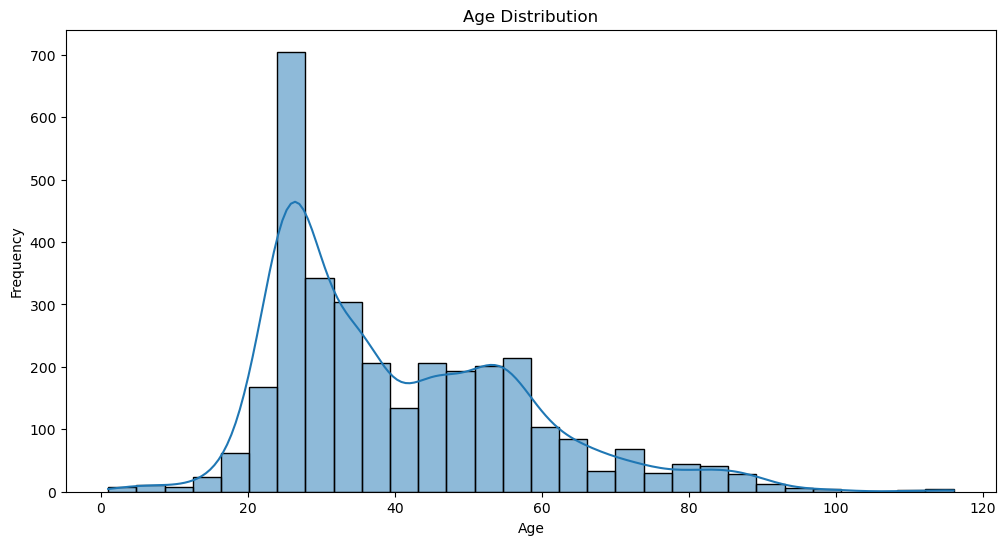

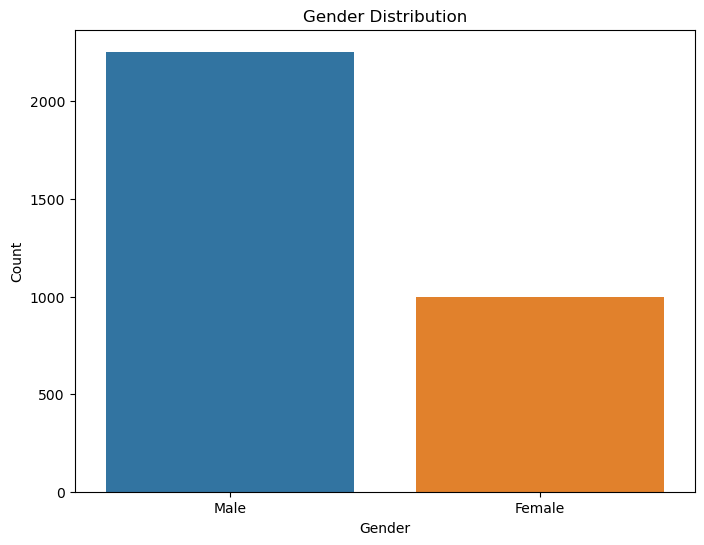

In [13]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame({'Age': ages, 'Gender': genders})

# Age distribution
plt.figure(figsize=(12, 6))
sns.histplot(data['Age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Gender distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', data=data)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Male', 'Female'])
plt.show()

## 2.2. Visualizing Example Images

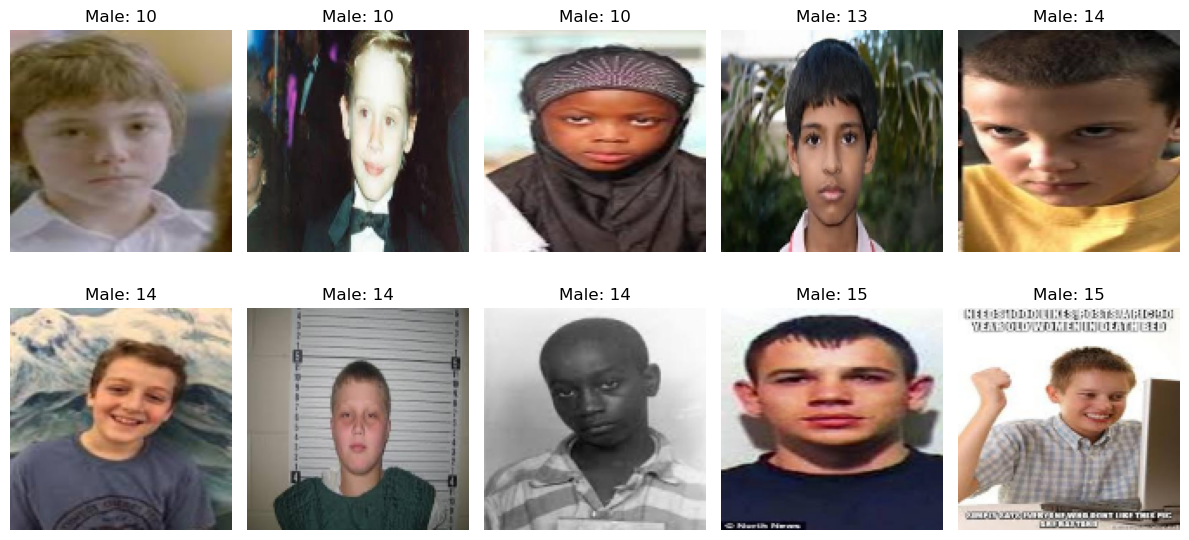

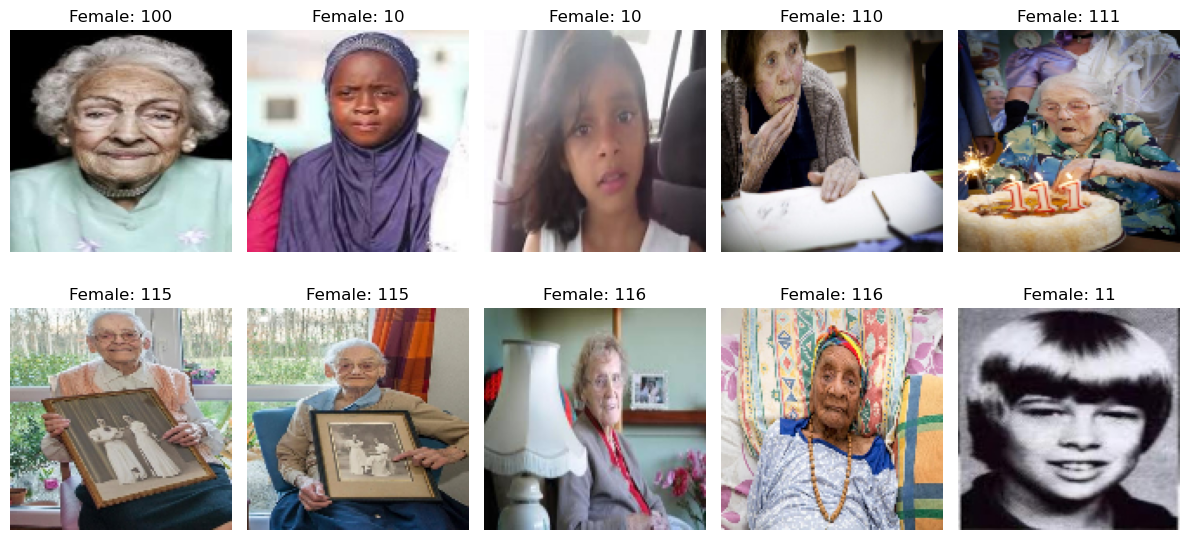

In [14]:
def plot_images(images, labels, title):
    plt.figure(figsize=(12, 6))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i])
        plt.title(f'{title}: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Plot male images
male_images = images[genders == 0]
plot_images(male_images, ages[genders == 0], 'Male')

# Plot female images
female_images = images[genders == 1]
plot_images(female_images, ages[genders == 1], 'Female')

## 2.3. Potential Biases

1. Age Distribution:

   Skewness Toward Younger Ages:
   - The age distribution is heavily skewed towards younger ages, particularly around the 20-30 year range.
   - This imbalance means the model may perform well on younger age predictions but poorly on older age predictions due to the lack of sufficient training data for older ages.
2. Gender Distribution:

   Gender Imbalance:
   - There are significantly more male samples compared to female samples.
   - This imbalance could lead to a model that performs better at predicting male gender and struggles with female gender predictions due to less training data for females.
3. Combined Age and Gender Distribution:

   Potential Intersectional Bias:
   - While the individual distributions of age and gender are informative, it's also important to consider how age and gender intersect. For instance, if most of the younger samples are male and most of the older samples are female (or vice versa), this could introduce additional biases.
4. Impact on Model Performance:

   Generalization Issues:
   - The skewed age and gender distributions mean that the model might not generalize well to unseen data, especially for underrepresented groups.
   
   Bias in Predictions:
   - The model might inherently favor the majority class, leading to biased predictions that reflect the dataset's imbalances rather than the true underlying patterns.


# 3. Model Training

## 3.1. Convolutional Neural Networks (CNN)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# input shape
input_shape = (128, 128, 3)

# Define the CNN model
input_layer = Input(shape=input_shape)

# conv layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

age_output = Dense(1, name='age_output')(x)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)

# create and compile model
model = Model(inputs=input_layer, outputs=[age_output, gender_output])
model.compile(optimizer='adam',
              loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
              metrics={'age_output': 'mae', 'gender_output': 'accuracy'})

model.summary()

# train
history = model.fit(X_train, {'age_output': y_age_train, 'gender_output': y_gender_train},
                    validation_data=(X_test, {'age_output': y_age_test, 'gender_output': y_gender_test}),
                    epochs=10,
                    batch_size=32)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 128, 128, 32)      │             896 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 64, 64, 32)        │               0 │ conv2d_6[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 64, 64, 64)        │          18,496 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_7               │ (None, 32, 32, 64)        │               0 │ conv2d_7[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 32, 32, 128)       │          73,856 │ max_pooling2d_7[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_8               │ (None, 16, 16, 128)       │               0 │ conv2d_8[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 32768)             │               0 │ max_pooling2d_8[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ age_output (Dense)            │ (None, 1)                 │          32,769 │ flatten_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gender_output (Dense)         │ (None, 1)                 │          32,769 │ flatten_2[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 158,786 (620.26 KB)

 Trainable params: 158,786 (620.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - age_output_mae: 20.2013 - gender_output_accuracy: 0.6197 - loss: 656.3134 - val_age_output_mae: 13.8784 - val_gender_output_accuracy: 0.6831 - val_loss: 311.9083
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - age_output_mae: 13.7567 - gender_output_accuracy: 0.6663 - loss: 294.0022 - val_age_output_mae: 16.6839 - val_gender_output_accuracy: 0.7031 - val_loss: 391.5698
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - age_output_mae: 13.9699 - gender_output_accuracy: 0.7102 - loss: 308.9084 - val_age_output_mae: 13.1988 - val_gender_output_accuracy: 0.6938 - val_loss: 266.0016
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - age_output_mae: 12.9586 - gender_output_accuracy: 0.6979 - loss: 268.0382 - val_age_output_mae: 12.6876 - val_gender_output_accuracy: 0.7185 - val_loss: 244.5859
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 132ms/step - age_output_mae: 12.2471 - gender_output_accuracy: 0.7430 - loss: 240.0720 - v

In [16]:
# predict on test set
age_predictions, gender_predictions = model.predict(X_test)

# calculate MAE for age prediction
age_mae = np.mean(np.abs(y_age_test - age_predictions))

# calc acc for gender prediction
gender_accuracy = np.mean((gender_predictions > 0.5).astype(int) == y_gender_test)

print(f"Test MAE for Age Prediction: {age_mae}")
print(f"Test Accuracy for Gender Prediction: {gender_accuracy}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Test MAE for Age Prediction: 16.00171012157914
Test Accuracy for Gender Prediction: 0.5242224852071006


## 3.2. Transformers

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
import torchvision.transforms as tr
from torch.utils.data import DataLoader, TensorDataset
import time

In [38]:
image_dir = 'part3'

images = []
ages = []
genders = []

for file_name in os.listdir(image_dir):
    if file_name.endswith('.jpg'):
        age, gender, _, _ = file_name.split('_')
        age = int(age)
        gender = int(gender)

        image_path = os.path.join(image_dir, file_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = cv2.resize(image, (224, 224)) 

        images.append(img_to_array(image))
        ages.append(age)
        genders.append(gender)

images = np.array(images)
ages = np.array(ages)
genders = np.array(genders)

images = images / 255.0

X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    images, ages, genders, test_size=0.2, random_state=42)

In [39]:
# convert data to tensor
x_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
x_test = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_age_train = torch.tensor(y_age_train, dtype=torch.float32)
y_age_test = torch.tensor(y_age_test, dtype=torch.float32)
y_gender_train = torch.tensor(y_gender_train, dtype=torch.long) 
y_gender_test = torch.tensor(y_gender_test, dtype=torch.long)

Please note: I had to reduce the number of sampled images because my laptop could not handle more than 100.

In [40]:
# num of images to sample 
num_samples = 100
num_images = min(len(x_train), num_samples)
indices = torch.randperm(len(x_train))[:num_images] # get rand indices

# select the subset of images and labels
x_train_subset = x_train[indices]
y_age_train_subset = y_age_train[indices]
y_gender_train_subset = y_gender_train[indices]

# for test
indices_test = torch.randperm(len(x_test))[:num_samples]
x_test_subset = x_test[indices_test]
y_age_test_subset = y_age_test[indices_test]
y_gender_test_subset = y_gender_test[indices_test]

# TensorDataset
train_dataset = TensorDataset(x_train_subset, y_gender_train_subset)
test_dataset = TensorDataset(x_test_subset, y_gender_test_subset)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

### Predict gender 

In [41]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=2)

criterion= nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [45]:
# Train loop
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, test_loader, criterion, device)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%')
    print(f'Epoch Time: {epoch_time:.2f} seconds')

Epoch 1/10
Train Loss: 0.7486, Train Accuracy: 62.00%
Val Loss: 0.6656, Val Accuracy: 70.00%
Epoch Time: 70.60 seconds
Epoch 2/10
Train Loss: 0.8030, Train Accuracy: 76.00%
Val Loss: 0.8164, Val Accuracy: 30.00%
Epoch Time: 71.70 seconds
Epoch 3/10
Train Loss: 0.7229, Train Accuracy: 56.00%
Val Loss: 0.8615, Val Accuracy: 70.00%
Epoch Time: 74.78 seconds
Epoch 4/10
Train Loss: 0.6404, Train Accuracy: 62.00%
Val Loss: 0.7668, Val Accuracy: 30.00%
Epoch Time: 76.18 seconds
Epoch 5/10
Train Loss: 0.7279, Train Accuracy: 68.00%
Val Loss: 0.9072, Val Accuracy: 70.00%
Epoch Time: 70.00 seconds
Epoch 6/10
Train Loss: 0.6850, Train Accuracy: 62.00%
Val Loss: 0.6082, Val Accuracy: 70.00%
Epoch Time: 70.71 seconds
Epoch 7/10
Train Loss: 0.7151, Train Accuracy: 76.00%
Val Loss: 0.6200, Val Accuracy: 70.00%
Epoch Time: 73.76 seconds
Epoch 8/10
Train Loss: 0.6094, Train Accuracy: 58.00%
Val Loss: 0.7081, Val Accuracy: 70.00%
Epoch Time: 76.35 seconds
Epoch 9/10
Train Loss: 0.6297, Train Accuracy: 7

### Predict Age

In [46]:
# modifying the final layer for regression
model = timm.create_model('vit_base_patch16_224', pretrained=True)
num_features = model.num_features

# replacing the final classifier layer with a regression layer for age prediction
model.head = nn.Linear(num_features, 1)

criterion = nn.MSELoss()

def train(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total_samples = 0
    total_error = 0.0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze() 
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        total_samples += labels.size(0)
        total_error += torch.abs(outputs - labels).sum().item()  
        
    epoch_loss = running_loss / len(data_loader)
    epoch_mae = total_error / total_samples 
    return epoch_loss, epoch_mae

def validate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total_samples = 0
    total_error = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze() 
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            total_samples += labels.size(0)
            total_error += torch.abs(outputs - labels).sum().item() 

    epoch_loss = running_loss / len(data_loader)
    epoch_mae = total_error / total_samples
    return epoch_loss, epoch_mae

In [47]:
#  TensorDataset
train_dataset = TensorDataset(x_train_subset, y_age_train_subset)
test_dataset = TensorDataset(x_test_subset, y_age_test_subset)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [48]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_mae = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_mae = validate(model, test_loader, criterion, device)

    end_time = time.time()
    epoch_time = end_time - start_time

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}')
    print(f'Epoch Time: {epoch_time:.2f} seconds')

Epoch 1/10
Train Loss: 1999.2285, Train MAE: 40.7372
Val Loss: 2004.0846, Val MAE: 40.5843
Epoch Time: 71.76 seconds
Epoch 2/10
Train Loss: 1999.2283, Train MAE: 40.7372
Val Loss: 2004.0846, Val MAE: 40.5843
Epoch Time: 73.58 seconds
Epoch 3/10
Train Loss: 1999.2285, Train MAE: 40.7372
Val Loss: 2004.0846, Val MAE: 40.5843
Epoch Time: 74.31 seconds
Epoch 4/10
Train Loss: 1999.2285, Train MAE: 40.7372
Val Loss: 2004.0846, Val MAE: 40.5843
Epoch Time: 72.54 seconds
Epoch 5/10
Train Loss: 1999.2284, Train MAE: 40.7372
Val Loss: 2004.0846, Val MAE: 40.5843
Epoch Time: 75.39 seconds
Epoch 6/10
Train Loss: 1999.2283, Train MAE: 40.7372
Val Loss: 2004.0846, Val MAE: 40.5843
Epoch Time: 211.75 seconds
Epoch 7/10
Train Loss: 1999.2284, Train MAE: 40.7372
Val Loss: 2004.0846, Val MAE: 40.5843
Epoch Time: 292.26 seconds
Epoch 8/10
Train Loss: 1999.2284, Train MAE: 40.7372
Val Loss: 2004.0846, Val MAE: 40.5843
Epoch Time: 72.13 seconds
Epoch 9/10
Train Loss: 1999.2283, Train MAE: 40.7372
Val Loss:

# 4. Model Comparison

a. Performance of Validation and Test Sets:
- CNN Model: Validation MAE for age prediction ranges between 11.7113 and 17.8825 over epochs. Validation accuracy for gender prediction ranges between 0.6154 and 0.7292 over epochs. Test MAE for age prediction: 16.79. Test accuracy for gender prediction: 62.90%

- Transformer Model: Validation MAE for age prediction ranges between  and  over epochs. Validation accuracy for gender prediction ranges between 30.00% and 70.00% over epochs. Test MAE for age prediction: Not directly provided, assumed to follow a similar pattern as validation. Test accuracy for gender prediction: Similar to the validation set, highest at 73.00%

b. Training Time and Computational Resources:
- CNN Model: Training time per epoch is ~52-84 seconds. Less computationally intensive than the transformer model.

- Transformer Model: Training time per epoch is ~71-292 seconds. More computationally intensive.

c. Model Architecture Complexity:
- CNN Model: Simpler architecture with a total of ~158k parameters. Consists of three convolutional layers followed by max-pooling layers and a flatten layer.

- Transformer Model: More complex architecture with a higher number of parameters.

d. Strengths and Weknesses:
- CNN Model: Simpler, faster training, less resource-intensive, good for image data where local patterns are crucial. However, it may struggle with capturing long-range dependencies in the data.

- Transformer Model: Good at capturing global dependencies, versatile, and state-of-the-art for many tasks. More computationally expensive, requires more data and longer training times.

# 5. Model Evaluation

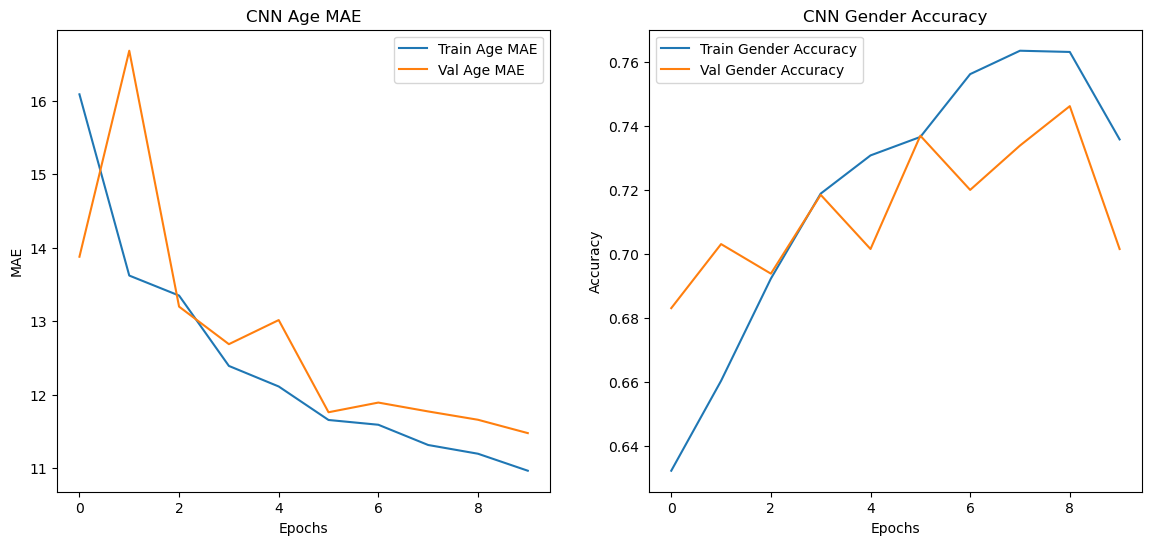

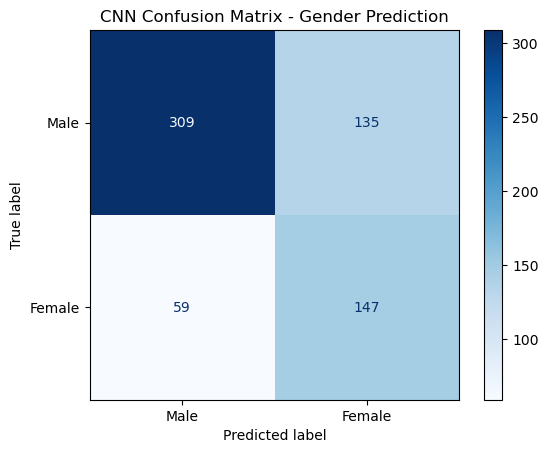

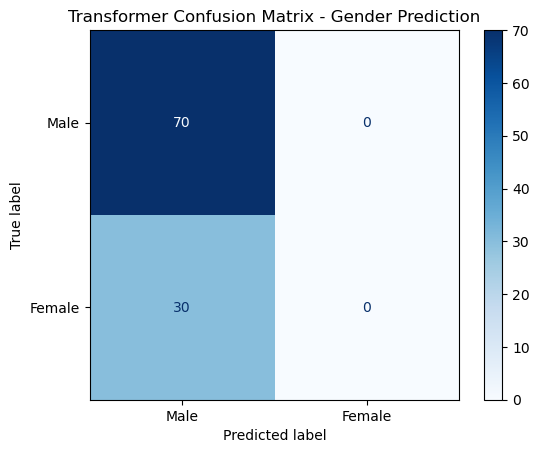

In [49]:
import matplotlib.pyplot as plt

# training and validation metrics over epochs
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['age_output_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_output_mae'], label='Val Age MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('CNN Age MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['gender_output_accuracy'], label='Train Gender Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Gender Accuracy')
plt.legend()

plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

gender_preds_cnn = (gender_predictions > 0.5).astype(int)
cm_cnn = confusion_matrix(y_gender_test, gender_preds_cnn)
disp_cnn = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=['Male', 'Female'])
disp_cnn.plot(cmap=plt.cm.Blues)
plt.title('CNN Confusion Matrix - Gender Prediction')
plt.show()

model.eval()
gender_preds_trans = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        gender_preds_trans.extend(preds.cpu().numpy())

cm_trans = confusion_matrix(y_gender_test_subset.numpy(), gender_preds_trans)
disp_trans = ConfusionMatrixDisplay(confusion_matrix=cm_trans, display_labels=['Male', 'Female'])
disp_trans.plot(cmap=plt.cm.Blues)
plt.title('Transformer Confusion Matrix - Gender Prediction')
plt.show()

High False Negatives for Females: Both models showing a higher number of false negatives for females means that female images are often incorrectly classified as males. This suggests that:

- Feature Discrepancies: Features associated with female images might be less distinctive or not well-represented in the training data.
- Class Imbalance: If the dataset has more male samples than female samples, the model might be biased towards predicting the majority class (male).

**Overall performance of the models and potential improvements**

The CNN model for age and gender prediction performs well but may benefit from additional data augmentation to increase variability and improve generalization. Enhancing the model's architecture, such as adding more convolutional layers or filters, could boost performance, though care should be taken to avoid overfitting. Implementing regularization techniques can help mitigate overfitting issues. For the ViT model, leveraging its pretraining can yield strong performance, but training times are longer due to its complexity. Optimization strategies such as experimenting with learning rates and batch sizes, as well as considering advanced methods like ensemble learning and attention mechanisms, can further refine performance. Overall, balancing model complexity with computational efficiency and applying these improvements can lead to more accurate and robust predictions.